In [1]:
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pandas as pd

In [2]:
results_folder = Path("results/hotspot_20")

In [3]:

def extend_sb_record(record: dict):
    """Extends a dataframe over the SmallBank benchmark with additional columns"""
    total_weight = record["smallBank_programBalanceSamplingWeight"] + \
        record["smallBank_programDepositCheckingSamplingWeight"] + \
        record["smallBank_programTransactSavingsSamplingWeight"] + \
        record["smallBank_programAmalgamateSamplingWeight"] + \
        record["smallBank_programWriteCheckSamplingWeight"]
    record["smallBank_programBalanceFraction"] = record["smallBank_programBalanceSamplingWeight"] / total_weight
    prom_strategy = f"Bal:{record['smallBank_programBalanceIsPromoted']}, WC:{record['smallBank_programWriteCheckIsPromoted']}"
    record["smallBank_promotionStrategy"] = prom_strategy
    used_ils = [
        record["smallBank_programBalanceAllocatedIsolationLevel"],
        record["smallBank_programDepositCheckingAllocatedIsolationLevel"],
        record["smallBank_programTransactSavingsAllocatedIsolationLevel"],
        record["smallBank_programAmalgamateAllocatedIsolationLevel"],
        record["smallBank_programWriteCheckAllocatedIsolationLevel"]
    ]
    category = "Detected"
    if used_ils == ["RC", "RC", "RC", "RC", "RC"]:
        category = "RC"
    elif used_ils == ["SI", "SI", "SI", "SI", "SI"]:
        category = "SI"
    elif used_ils == ["SSI", "SSI", "SSI", "SSI", "SSI"]:
        category = "SSI"
    record["smallBank_isolationLevelCategory"] = category
    record["smallBank_allocation"] = f"Bal: {used_ils[0]}, DC: {used_ils[1]}, TS: {used_ils[2]}, Am: {used_ils[3]}, WC: {used_ils[4]}"

def collect_data(results_folder: Path) -> pd.DataFrame:
    """Extract data from json files into a dataframe"""
    files = results_folder.glob("*.json")
    json_data = []
    for file in files:
        with open(file, "r", encoding="utf-8") as f:
            json_data.append(json.load(f))
    data = []
    for jd in json_data:
        config = jd["config"]
        benchmark_name = config["benchmark"]
        benchmark_config = config[benchmark_name]
        for sr, superrun in enumerate(jd["superruns"]):
            for r, run in enumerate(superrun["runs"]):
                abort_total = run["failed"]["deadlock"] + run["failed"]["concurrentWrite"] + run["failed"]["dangerousStructure"]
                row = {
                    "experimentName": config["experimentName"],
                    "concurrentClients": config["concurrentClients"],
                    "runtime": config["timing"]["experiment"],
                    "category": config["category"],
                    "robust": config["robust"],
                    "benchmark": benchmark_name,
                    "superrun": sr,
                    "run": r,
                    "completedTotal": run["completedTotal"],
                    "throughput": run["completedTotal"] / config["timing"]["experiment"],
                    "abortTotal": abort_total,
                    "abortRate": abort_total / config["timing"]["experiment"],
                }
                for name, total in run["completed"].items():
                    row[f"completed_{name}"] = total
                for name, total in run["failed"].items():
                    row[f"failed_{name}"] = total
                for k, v in benchmark_config.items():
                    row[f"{benchmark_name}_{k}"] = v
                if benchmark_name == "smallBank":
                    extend_sb_record(row)
                data.append(row)
    df = pd.DataFrame.from_records(data)
    return df

data = collect_data(results_folder)

data

,experimentName,concurrentClients,runtime,category,robust,benchmark,superrun,run,completedTotal,throughput,...,smallBank_programWriteCheckSamplingWeight,smallBank_programWriteCheckAllocatedIsolationLevel,smallBank_programWriteCheckIsPromoted,smallBank_accountSamplingMethod,smallBank_hotspotProbability,smallBank_hotspotSize,smallBank_programBalanceFraction,smallBank_promotionStrategy,smallBank_isolationLevelCategory,smallBank_allocation
0,Promoted_3_0,100,60,detected,true,smallBank,0,0,4552847,75880.783333,...,1,SI,false,hotspot,0.1,20,0.2,"Bal:Checking, WC:false",Detected,"Bal: SI, DC: RC, TS: RC, Am: RC, WC: SI"
1,Promoted_3_0,100,60,detected,true,smallBank,1,0,4588840,76480.666667,...,1,SI,false,hotspot,0.1,20,0.2,"Bal:Checking, WC:false",Detected,"Bal: SI, DC: RC, TS: RC, Am: RC, WC: SI"
2,Promoted_3_0,100,60,detected,true,smallBank,2,0,4564438,76073.966667,...,1,SI,false,hotspot,0.1,20,0.2,"Bal:Checking, WC:false",Detected,"Bal: SI, DC: RC, TS: RC, Am: RC, WC: SI"
3,Promoted_3_0,100,60,detected,true,smallBank,3,0,4516466,75274.433333,...,1,SI,false,hotspot,0.1,20,0.2,"Bal:Checking, WC:false",Detected,"Bal: SI, DC: RC, TS: RC, Am: RC, WC: SI"
4,Promoted_3_0,100,60,detected,true,smallBank,4,0,4553958,75899.300000,...,1,SI,false,hotspot,0.1,20,0.2,"Bal:Checking, WC:false",Detected,"Bal: SI, DC: RC, TS: RC, Am: RC, WC: SI"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,Promoted_3_3,100,60,detected,true,smallBank,0,0,1705104,28418.400000,...,1,SI,Checking,hotspot,0.9,20,0.2,"Bal:Checking, WC:Checking",Detected,"Bal: SI, DC: RC, TS: RC, Am: RC, WC: SI"
446,Promoted_3_3,100,60,detected,true,smallBank,1,0,1744189,29069.816667,...,1,SI,Checking,hotspot,0.9,20,0.2,"Bal:Checking, WC:Checking",Detected,"Bal: SI, DC: RC, TS: RC, Am: RC, WC: SI"
447,Promoted_3_3,100,60,detected,true,smallBank,2,0,1681337,28022.283333,...,1,SI,Checking,hotspot,0.9,20,0.2,"Bal:Checking, WC:Checking",Detected,"Bal: SI, DC: RC, TS: RC, Am: RC, WC: SI"
448,Promoted_3_3,100,60,detected,true,smallBank,3,0,1722019,28700.316667,...,1,SI,Checking,hotspot,0.9,20,0.2,"Bal:Checking, WC:Checking",Detected,"Bal: SI, DC: RC, TS: RC, Am: RC, WC: SI"


In [4]:
data["smallBank_promotionStrategy"].unique()

array(['Bal:Checking, WC:false', 'Bal:Checking, WC:Savings',
       'Bal:Savings, WC:Checking', 'Bal:false, WC:Checking',
       'Bal:SavingsChecking, WC:Checking',
       'Bal:SavingsChecking, WC:SavingsChecking',
       'Bal:Checking, WC:SavingsChecking', 'Bal:Checking, WC:Checking',
       'Bal:false, WC:false', 'Bal:false, WC:Savings',
       'Bal:Savings, WC:SavingsChecking', 'Bal:false, WC:SavingsChecking',
       'Bal:Savings, WC:Savings', 'Bal:Savings, WC:false',
       'Bal:SavingsChecking, WC:false', 'Bal:SavingsChecking, WC:Savings'],
      dtype=object)

In [5]:
data["category"].unique()

array(['detected', 'all_SSI', 'all_RC'], dtype=object)

In [6]:

hue_order = sorted(data["smallBank_allocation"].unique())


In [7]:
# define custom sort order matching the order in the paper.
alloc_order = sorted(data["smallBank_allocation"].unique(), reverse=True)

alloc_order[0], alloc_order[1] = alloc_order[1], alloc_order[0]
alloc_order

['Bal: SSI, DC: RC, TS: SSI, Am: SSI, WC: SSI',
 'Bal: SSI, DC: SSI, TS: SSI, Am: SSI, WC: SSI',
 'Bal: SI, DC: RC, TS: RC, Am: RC, WC: SI',
 'Bal: SI, DC: RC, TS: RC, Am: RC, WC: RC',
 'Bal: RC, DC: RC, TS: RC, Am: RC, WC: SI',
 'Bal: RC, DC: RC, TS: RC, Am: RC, WC: RC']

In [8]:

data.sort_values("smallBank_allocation", key=lambda col: col.map(lambda c: alloc_order.index(c)), inplace=True)

hue_order = sorted(data["smallBank_allocation"].unique())

data_detected = data[data["category"] == "detected"]
data_upper = data[data["category"] == "all_RC"]
data_lower = data[data["category"] == "all_SSI"]

data_best = data[data["experimentName"] == "Promoted_0_23"]
data_no_prom = data[data["experimentName"] == "Promoted_0_0 (default)"]

allocations = sorted(data["smallBank_allocation"].unique())
allocations

['Bal: RC, DC: RC, TS: RC, Am: RC, WC: RC',
 'Bal: RC, DC: RC, TS: RC, Am: RC, WC: SI',
 'Bal: SI, DC: RC, TS: RC, Am: RC, WC: RC',
 'Bal: SI, DC: RC, TS: RC, Am: RC, WC: SI',
 'Bal: SSI, DC: RC, TS: SSI, Am: SSI, WC: SSI',
 'Bal: SSI, DC: SSI, TS: SSI, Am: SSI, WC: SSI']

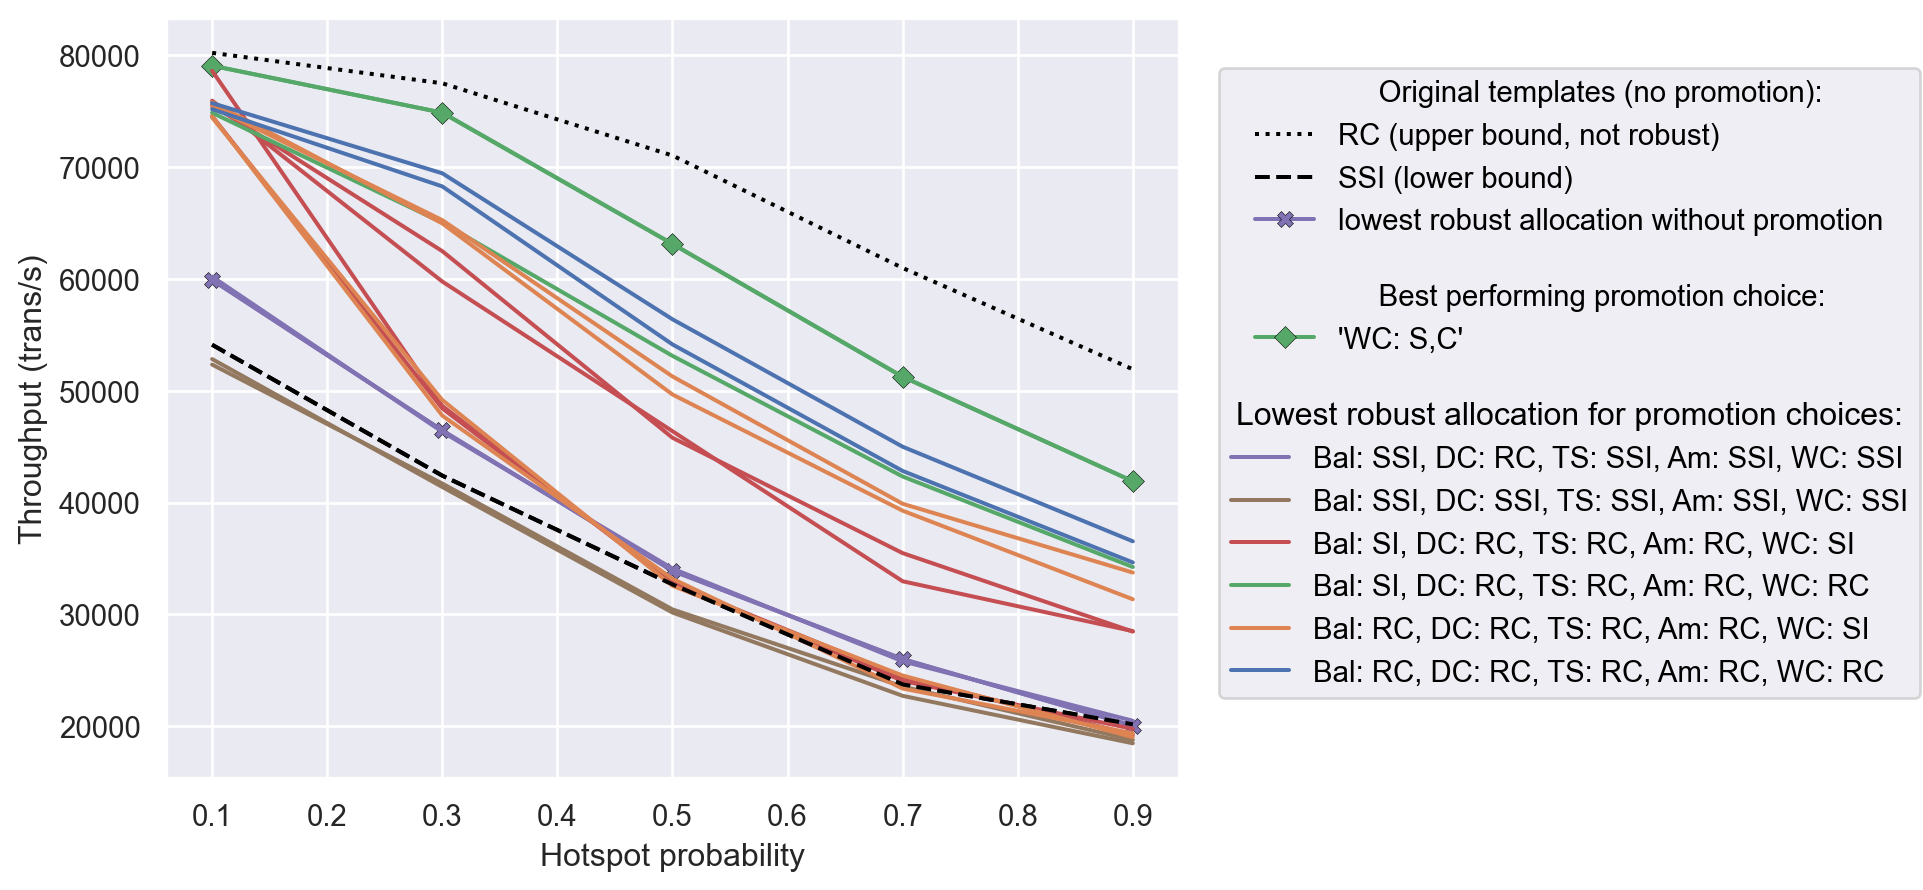

In [9]:
color_map = {a: f"C{i}" for i, a in enumerate(allocations)}

g = (
so.Plot(data=data, x="smallBank_hotspotProbability", y="throughput", group="smallBank_promotionStrategy")
    .add(so.Line(color="white", linestyle=":",linewidth=0.01), so.Agg(), data=data_upper, label="     Original templates (no promotion):")
    .add(so.Line(color="black", linestyle=":"), so.Agg(), data=data_upper, label="RC (upper bound, not robust)")
    .add(so.Line(color="black", linestyle="--"), so.Agg(), data=data_lower, label="SSI (lower bound)")
    .add(so.Line(marker="X", color="C4", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_no_prom, label="lowest robust allocation without promotion")
    .add(so.Line(color="white", linewidth=0.01), so.Agg(), data=data_best, label="\n     Best performing promotion choice:")
    .add(so.Line(marker="D", color="C2", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_best, label="'WC: S,C'")
    .add(so.Line(marker=','), so.Agg(), data=data_detected, color="smallBank_allocation", marker=None)
    # Additional copy of line without label to draw on top, even though listed earlier in the legend
    .add(so.Line(color="black", linestyle="--"), so.Agg(), data=data_lower)
    #.add(so.Band(), so.Est())
    .scale(color=color_map)
    .label(color="\nLowest robust allocation for promotion choices:", x="Hotspot probability", y="Throughput (trans/s)")
)

g.plot()

In [10]:
data_23_0 = data[data["experimentName"] == "Promoted_23_0"]
data_2_2 = data[data["experimentName"] == "Promoted_2_2"]
data_23_2 = data[data["experimentName"] == "Promoted_23_2"]
data_23_3 = data[data["experimentName"] == "Promoted_23_3"]

data_combined = pd.concat([data_23_0, data_2_2, data_23_2, data_23_3])
data_combined

,experimentName,concurrentClients,runtime,category,robust,benchmark,superrun,run,completedTotal,throughput,...,smallBank_programWriteCheckSamplingWeight,smallBank_programWriteCheckAllocatedIsolationLevel,smallBank_programWriteCheckIsPromoted,smallBank_accountSamplingMethod,smallBank_hotspotProbability,smallBank_hotspotSize,smallBank_programBalanceFraction,smallBank_promotionStrategy,smallBank_isolationLevelCategory,smallBank_allocation
100,Promoted_23_0,100,60,detected,true,smallBank,0,0,3915860,65264.333333,...,1,SI,false,hotspot,0.3,20,0.2,"Bal:SavingsChecking, WC:false",Detected,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: SI"
101,Promoted_23_0,100,60,detected,true,smallBank,1,0,3918906,65315.100000,...,1,SI,false,hotspot,0.3,20,0.2,"Bal:SavingsChecking, WC:false",Detected,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: SI"
102,Promoted_23_0,100,60,detected,true,smallBank,2,0,3888282,64804.700000,...,1,SI,false,hotspot,0.3,20,0.2,"Bal:SavingsChecking, WC:false",Detected,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: SI"
103,Promoted_23_0,100,60,detected,true,smallBank,3,0,3870707,64511.783333,...,1,SI,false,hotspot,0.3,20,0.2,"Bal:SavingsChecking, WC:false",Detected,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: SI"
423,Promoted_23_0,100,60,detected,true,smallBank,3,0,4545335,75755.583333,...,1,SI,false,hotspot,0.1,20,0.2,"Bal:SavingsChecking, WC:false",Detected,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: SI"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Promoted_23_3,100,60,detected,true,smallBank,4,0,3866979,64449.650000,...,1,SI,Checking,hotspot,0.3,20,0.2,"Bal:SavingsChecking, WC:Checking",Detected,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: SI"
143,Promoted_23_3,100,60,detected,true,smallBank,3,0,3955986,65933.100000,...,1,SI,Checking,hotspot,0.3,20,0.2,"Bal:SavingsChecking, WC:Checking",Detected,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: SI"
142,Promoted_23_3,100,60,detected,true,smallBank,2,0,3953975,65899.583333,...,1,SI,Checking,hotspot,0.3,20,0.2,"Bal:SavingsChecking, WC:Checking",Detected,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: SI"
141,Promoted_23_3,100,60,detected,true,smallBank,1,0,3902781,65046.350000,...,1,SI,Checking,hotspot,0.3,20,0.2,"Bal:SavingsChecking, WC:Checking",Detected,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: SI"


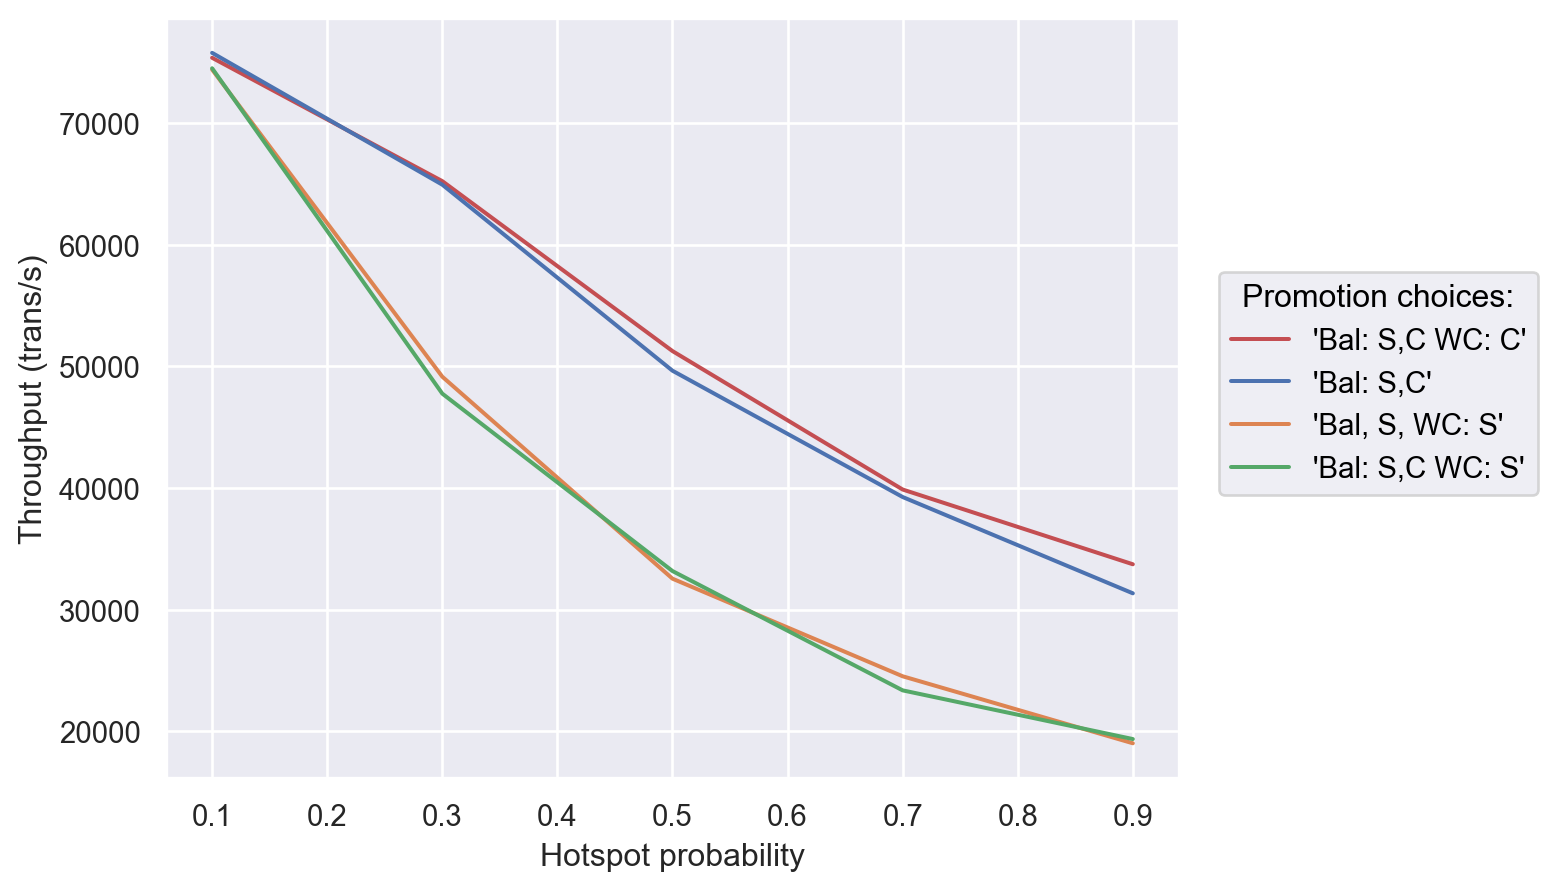

In [11]:
g = (
so.Plot(data=data_combined, x="smallBank_hotspotProbability", y="throughput", group="smallBank_promotionStrategy")
    #.add(so.Line(marker=','), so.Agg(), data=data_detected, color="smallBank_promotionStrategy", marker=None)
    #.add(so.Line(color="black", linestyle=":"), so.Agg(), data=data_upper, label="RC without promotion")
    #.add(so.Line(color="black", linestyle="--"), so.Agg(), data=data_lower, label="SSI without promotion")
    .add(so.Line(marker=",", color="C3"), so.Agg(), data=data_23_3, label="'Bal: S,C WC: C'")
    .add(so.Line(marker=",", color="C0"), so.Agg(), data=data_23_0, label="'Bal: S,C'")
    .add(so.Line(marker=",", color="C1"), so.Agg(), data=data_2_2, label="'Bal, S, WC: S'")
    .add(so.Line(marker=",", color="C2"), so.Agg(), data=data_23_2, label="'Bal: S,C WC: S'")
    #.add(so.Band(), so.Est())
    #.scale(color=color_map)
    .label(legend="Promotion choices:", x="Hotspot probability", y="Throughput (trans/s)")
)

g.plot()

In [12]:
optimality_folder = Path("results/hotspot_20_optimal_alloc")

data = collect_data(optimality_folder)

# define custom sort order matching the order in the paper.
alloc_order = sorted(data["smallBank_allocation"].unique(), reverse=True)

#alloc_order[0], alloc_order[1] = alloc_order[1], alloc_order[0]


data.sort_values("smallBank_allocation", key=lambda col: col.map(lambda c: alloc_order.index(c)), inplace=True)
data

,experimentName,concurrentClients,runtime,category,robust,benchmark,superrun,run,completedTotal,throughput,...,smallBank_programWriteCheckSamplingWeight,smallBank_programWriteCheckAllocatedIsolationLevel,smallBank_programWriteCheckIsPromoted,smallBank_accountSamplingMethod,smallBank_hotspotProbability,smallBank_hotspotSize,smallBank_programBalanceFraction,smallBank_promotionStrategy,smallBank_isolationLevelCategory,smallBank_allocation
224,Promoted_0_23,100,60,non-optimal,true,smallBank,4,0,1822409,30373.483333,...,1,SSI,SavingsChecking,hotspot,0.5,20,0.2,"Bal:false, WC:SavingsChecking",SSI,"Bal: SSI, DC: SSI, TS: SSI, Am: SSI, WC: SSI"
90,Promoted_0_23,100,60,non-optimal,true,smallBank,0,0,3235803,53930.050000,...,1,SSI,SavingsChecking,hotspot,0.1,20,0.2,"Bal:false, WC:SavingsChecking",SSI,"Bal: SSI, DC: SSI, TS: SSI, Am: SSI, WC: SSI"
91,Promoted_0_23,100,60,non-optimal,true,smallBank,1,0,3222356,53705.933333,...,1,SSI,SavingsChecking,hotspot,0.1,20,0.2,"Bal:false, WC:SavingsChecking",SSI,"Bal: SSI, DC: SSI, TS: SSI, Am: SSI, WC: SSI"
92,Promoted_0_23,100,60,non-optimal,true,smallBank,2,0,3165766,52762.766667,...,1,SSI,SavingsChecking,hotspot,0.1,20,0.2,"Bal:false, WC:SavingsChecking",SSI,"Bal: SSI, DC: SSI, TS: SSI, Am: SSI, WC: SSI"
93,Promoted_0_23,100,60,non-optimal,true,smallBank,3,0,3189861,53164.350000,...,1,SSI,SavingsChecking,hotspot,0.1,20,0.2,"Bal:false, WC:SavingsChecking",SSI,"Bal: SSI, DC: SSI, TS: SSI, Am: SSI, WC: SSI"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,Promoted_0_23,100,60,non-robust,false,smallBank,0,0,4621268,77021.133333,...,1,RC,SavingsChecking,hotspot,0.1,20,0.2,"Bal:false, WC:SavingsChecking",RC,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: RC"
160,Promoted_0_23,100,60,non-robust,false,smallBank,0,0,2511426,41857.100000,...,1,RC,SavingsChecking,hotspot,0.9,20,0.2,"Bal:false, WC:SavingsChecking",RC,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: RC"
39,Promoted_0_23,100,60,non-robust,false,smallBank,4,0,4617230,76953.833333,...,1,RC,SavingsChecking,hotspot,0.1,20,0.2,"Bal:false, WC:SavingsChecking",RC,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: RC"
211,Promoted_0_23,100,60,non-robust,false,smallBank,1,0,4429407,73823.450000,...,1,RC,SavingsChecking,hotspot,0.3,20,0.2,"Bal:false, WC:SavingsChecking",RC,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: RC"


In [13]:
data_optimal = data[data["category"] == "optimal"]
data_nonrobust = data[data["category"] == "non-robust"]
data_nonoptimal = data[data["category"] == "non-optimal"]

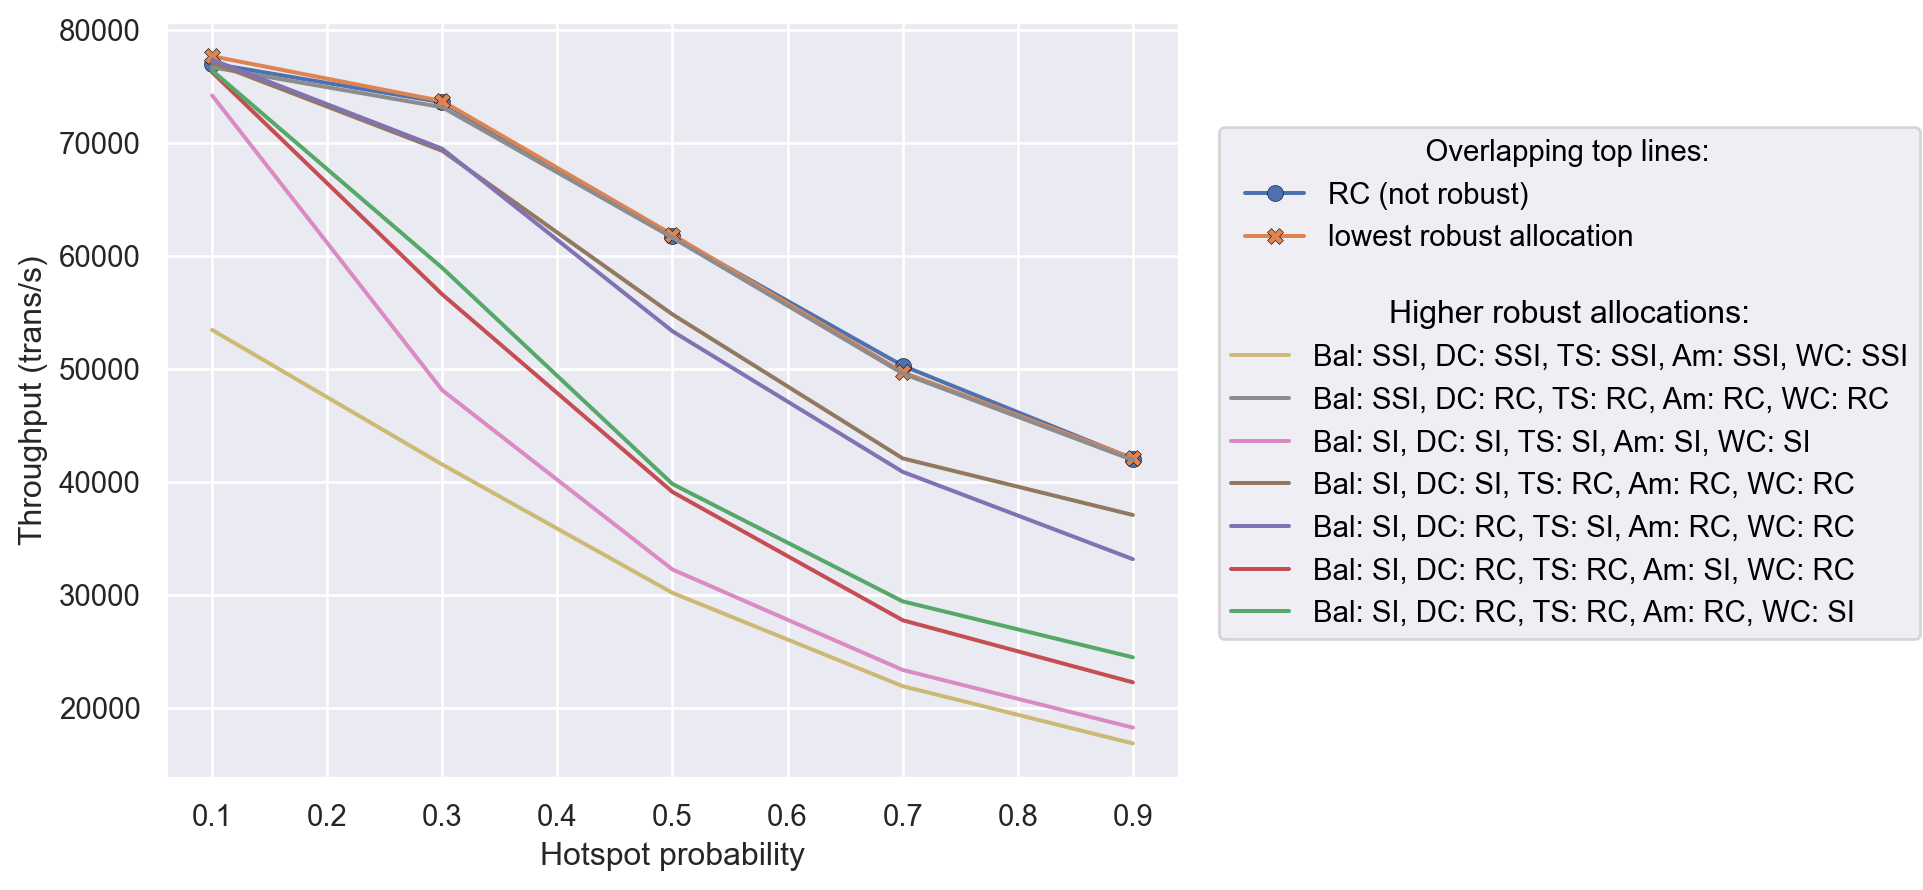

In [14]:
allocations = sorted(data_nonoptimal["smallBank_allocation"].unique())
color_map = {a: f"C{i+2}" for i, a in enumerate(allocations)}


g = (
so.Plot(data=data, x="smallBank_hotspotProbability", y="throughput", group="smallBank_allocation")
    .add(so.Line(color="white", linewidth=0.01), so.Agg(), data=data_nonrobust, label="            Overlapping top lines:")
    .add(so.Line(color="C0", marker='o', edgecolor="black", edgewidth=0.2), so.Agg(), data=data_nonrobust, label="RC (not robust)")
    .add(so.Line(color="C1", marker='X', edgecolor="black", edgewidth=0.2), so.Agg(), data=data_optimal, label="lowest robust allocation                                ")
    .add(so.Line(), so.Agg(), data=data_nonoptimal, color="smallBank_allocation")
    #.add(so.Line(color="C2"), so.Agg(), data=data_nonoptimal, label="non-optimal allocation")
    #.add(so.Line(color="C0", marker='x'), so.Agg(), data=data_optimal,label="optimal allocation")
    # .add(so.Line(color="black", linestyle=":"), so.Agg(), data=data_upper, label="RC without promotion")
    .scale(color=color_map)
    .label(color="\nHigher robust allocations:", x="Hotspot probability", y="Throughput (trans/s)")
)

g.plot()

In [15]:
readonly_folder = Path("results/hotspot_20_readonly")

data = collect_data(readonly_folder)
data = data[data["category"] == "detected"]
data = data.sort_values("smallBank_allocation")
data

,experimentName,concurrentClients,runtime,category,robust,benchmark,superrun,run,completedTotal,throughput,...,smallBank_programWriteCheckSamplingWeight,smallBank_programWriteCheckAllocatedIsolationLevel,smallBank_programWriteCheckIsPromoted,smallBank_accountSamplingMethod,smallBank_hotspotProbability,smallBank_hotspotSize,smallBank_programBalanceFraction,smallBank_promotionStrategy,smallBank_isolationLevelCategory,smallBank_allocation
199,Promoted_23_23,100,60,detected,true,smallBank,4,0,3379260,56321.000000,...,7,RC,SavingsChecking,hotspot,0.5,20,0.65,"Bal:SavingsChecking, WC:SavingsChecking",RC,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: RC"
320,Promoted_23_23,100,60,detected,true,smallBank,0,0,3420081,57001.350000,...,1,RC,SavingsChecking,hotspot,0.5,20,0.80,"Bal:SavingsChecking, WC:SavingsChecking",RC,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: RC"
244,Promoted_2_23,100,60,detected,true,smallBank,4,0,3474034,57900.566667,...,13,RC,SavingsChecking,hotspot,0.5,20,0.35,"Bal:Savings, WC:SavingsChecking",RC,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: RC"
243,Promoted_2_23,100,60,detected,true,smallBank,3,0,3466075,57767.916667,...,13,RC,SavingsChecking,hotspot,0.5,20,0.35,"Bal:Savings, WC:SavingsChecking",RC,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: RC"
242,Promoted_2_23,100,60,detected,true,smallBank,2,0,3472764,57879.400000,...,13,RC,SavingsChecking,hotspot,0.5,20,0.35,"Bal:Savings, WC:SavingsChecking",RC,"Bal: RC, DC: RC, TS: RC, Am: RC, WC: RC"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,Promoted_2_3,100,60,detected,true,smallBank,2,0,2487870,41464.500000,...,7,SSI,Checking,hotspot,0.5,20,0.65,"Bal:Savings, WC:Checking",SSI,"Bal: SSI, DC: SSI, TS: SSI, Am: SSI, WC: SSI"
368,Promoted_2_3,100,60,detected,true,smallBank,3,0,2547331,42455.516667,...,7,SSI,Checking,hotspot,0.5,20,0.65,"Bal:Savings, WC:Checking",SSI,"Bal: SSI, DC: SSI, TS: SSI, Am: SSI, WC: SSI"
201,Promoted_2_0,100,60,detected,true,smallBank,1,0,1877812,31296.866667,...,1,SSI,false,hotspot,0.5,20,0.20,"Bal:Savings, WC:false",SSI,"Bal: SSI, DC: SSI, TS: SSI, Am: SSI, WC: SSI"
223,Promoted_2_3,100,60,detected,true,smallBank,3,0,2860452,47674.200000,...,1,SSI,Checking,hotspot,0.5,20,0.80,"Bal:Savings, WC:Checking",SSI,"Bal: SSI, DC: SSI, TS: SSI, Am: SSI, WC: SSI"


In [16]:
data_best = data[data["experimentName"] == "Promoted_0_23"]
data_no_prom = data[data["experimentName"] == "Promoted_0_0 (default)"]

data_0_0 = data[data["experimentName"] == "Promoted_0_0 (default)"]
data_0_2 = data[data["experimentName"] == "Promoted_0_2"]
data_0_3 = data[data["experimentName"] == "Promoted_0_3"]
data_0_23 = data[data["experimentName"] == "Promoted_0_23"]
data_2_0 = data[data["experimentName"] == "Promoted_2_0"]
data_2_2 = data[data["experimentName"] == "Promoted_2_2"]
data_2_3 = data[data["experimentName"] == "Promoted_2_3"]
data_2_23 = data[data["experimentName"] == "Promoted_2_23"]
data_3_0 = data[data["experimentName"] == "Promoted_3_0"]
data_3_2 = data[data["experimentName"] == "Promoted_3_2"]
data_3_3 = data[data["experimentName"] == "Promoted_3_3"]
data_3_23 = data[data["experimentName"] == "Promoted_3_23"]
data_23_0 = data[data["experimentName"] == "Promoted_23_0"]
data_23_2 = data[data["experimentName"] == "Promoted_23_2"]
data_23_3 = data[data["experimentName"] == "Promoted_23_3"]
data_23_23 = data[data["experimentName"] == "Promoted_23_23"]

data_bal_readonly = data[data["smallBank_programBalanceIsPromoted"] == "false"]
data_bal_writes = data[data["smallBank_programBalanceIsPromoted"] != "false"]
#data["Balance_promoted"] = data["smallBank_programBalanceIsPromoted"] != "false"
#data.Balance_promoted.astype(bool)



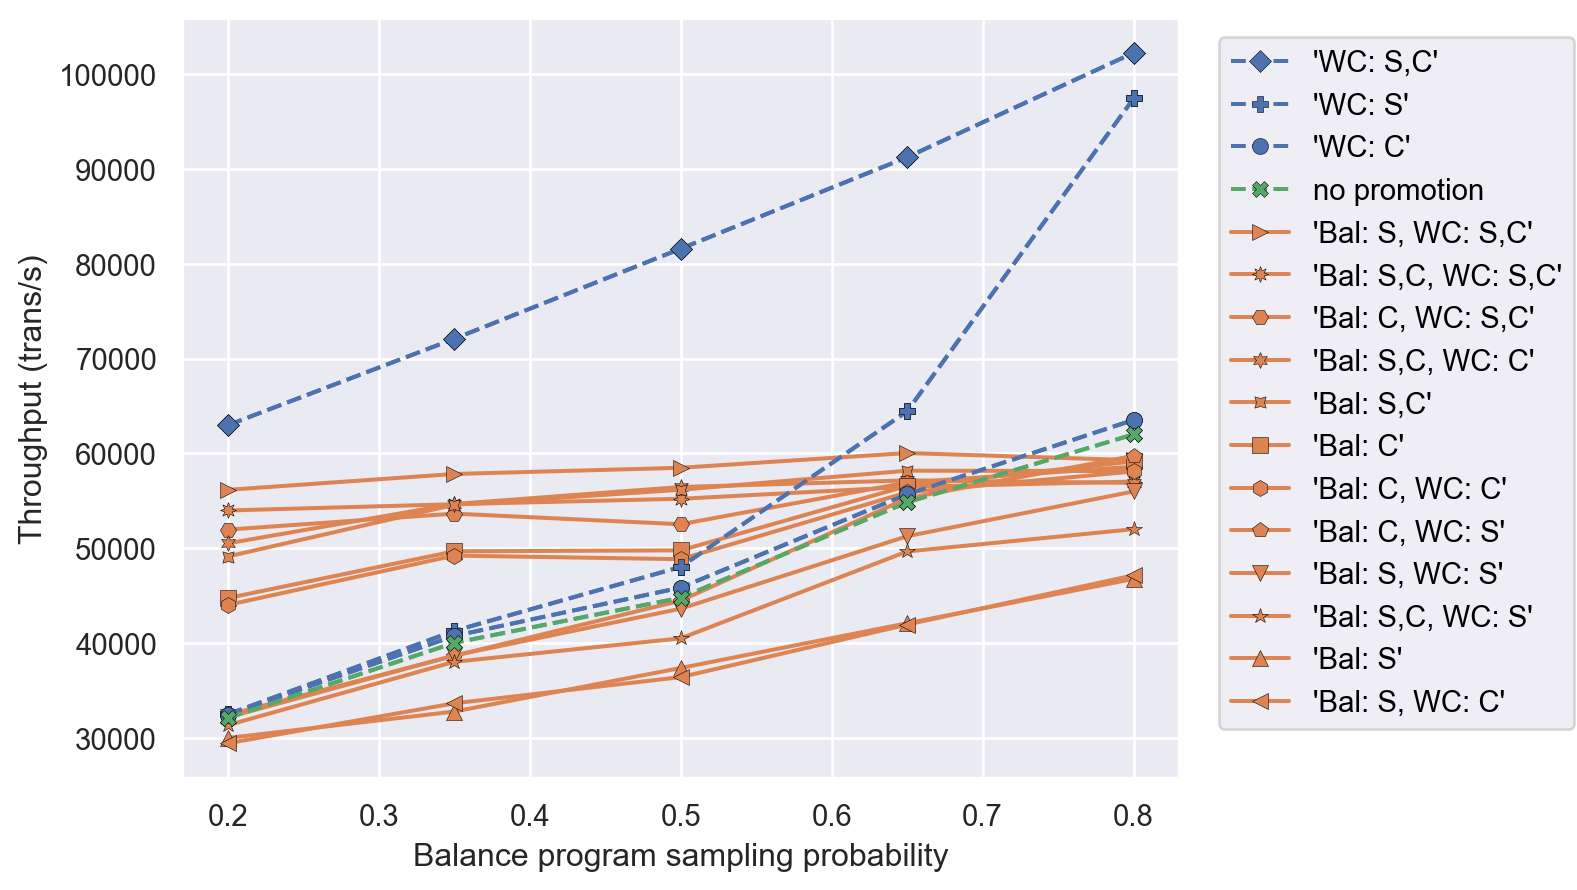

In [17]:
g = (
so.Plot(data=data, x="smallBank_programBalanceFraction", y="throughput", group="smallBank_promotionStrategy")
    #.add(so.Line(), so.Agg(), data=data, color="smallBank_promotionStrategy", linestyle="smallBank_programBalanceAllocatedIsolationLevel", marker=None)
    .add(so.Line(linestyle="--", color="C0", marker="D", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_0_23, label="'WC: S,C'")
    .add(so.Line(linestyle="--", color="C0", marker="P", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_0_2, label="'WC: S'")
    .add(so.Line(linestyle="--", color="C0", marker="o", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_0_3, label="'WC: C'")
    .add(so.Line(linestyle="--", color="C2", marker="X", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_0_0, label="no promotion")
    .add(so.Line(linestyle="-", color="C1", marker=">", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_2_23, label="'Bal: S, WC: S,C'")
    .add(so.Line(linestyle="-", color="C1", marker=(8,1,0), edgecolor="black", edgewidth=0.2), so.Agg(), data=data_23_23, label="'Bal: S,C, WC: S,C'")
    .add(so.Line(linestyle="-", color="C1", marker="H", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_3_23, label="'Bal: C, WC: S,C'")
    .add(so.Line(linestyle="-", color="C1", marker=(6,1,0), edgecolor="black", edgewidth=0.2), so.Agg(), data=data_23_3, label="'Bal: S,C, WC: C'")
    .add(so.Line(linestyle="-", color="C1", marker=(4,1,45), edgecolor="black", edgewidth=0.2), so.Agg(), data=data_23_0, label="'Bal: S,C'")
    .add(so.Line(linestyle="-", color="C1", marker="s", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_3_0, label="'Bal: C'")
    .add(so.Line(linestyle="-", color="C1", marker="h", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_3_3, label="'Bal: C, WC: C'")
    .add(so.Line(linestyle="-", color="C1", marker="p", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_3_2, label="'Bal: C, WC: S'")
    .add(so.Line(linestyle="-", color="C1", marker="v", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_2_2, label="'Bal: S, WC: S'")
    .add(so.Line(linestyle="-", color="C1", marker="*", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_23_2, label="'Bal: S,C, WC: S'")
    .add(so.Line(linestyle="-", color="C1", marker="^", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_2_0, label="'Bal: S'")
    .add(so.Line(linestyle="-", color="C1", marker="<", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_2_3, label="'Bal: S, WC: C'")
    #Extra copies to draw on top independent of legend order
    .add(so.Line(linestyle="--", color="C0", marker="D", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_0_23)
    .add(so.Line(linestyle="--", color="C0", marker="P", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_0_2)
    .add(so.Line(linestyle="--", color="C0", marker="o", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_0_3)
    .add(so.Line(linestyle="--", color="C2", marker="X", edgecolor="black", edgewidth=0.2), so.Agg(), data=data_0_0)
    #.add(so.Band(), so.Est())
    #.scale(color=color_map)
    .label(x="Balance program sampling probability", y="Throughput (trans/s)")
)

g.plot()